# Nhập thư viện


In [ ]:
import glob
import math
import os
import random
import time
from datetime import datetime, timedelta, timezone


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from pytrends.request import TrendReq
from pywaffle import Waffle
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.autolayout": True})


# Lấy và xử lý dữ liệu

Setup

In [ ]:
# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2023-01-01"       # ngày bắt đầu
END_DATE = datetime.today().strftime("%Y-%m-%d")       # ngày kết thúc

## Lấy file dữ liệu BTC


In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "BTC"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho BTC (BTCUSDT) từ 2023-01-01 → 2025-11-02, interval=1d


In [ ]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [ ]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [ ]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [ ]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [ ]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
[ERROR] 451 Client Error:  for url: https://fapi.binance.com/fapi/v1/klines?symbol=BTCUSDT&interval=1d&startTime=1672531200000&endTime=1762127999000&limit=1000
[WARN] Không lấy được dữ liệu Klines.
klines rows: 0
Fetching funding rates...


HTTPError: 451 Client Error:  for url: https://fapi.binance.com/fapi/v1/fundingRate?symbol=BTCUSDT&startTime=1672531200000&endTime=1762127999000&limit=1000

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


## Lấy file dữ liệu ETH


In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "ETH"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

In [ ]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [ ]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [ ]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [ ]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [ ]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


## Lấy file dữ liệu BNB


In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "BNB"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

In [ ]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [ ]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [ ]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [ ]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [ ]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


## Lấy file dữ liệu SOL


In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "SOL"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

In [ ]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [ ]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [ ]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [ ]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [ ]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


## Lấy file dữ liệu XRP


In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "XRP"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

In [ ]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [ ]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [ ]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [ ]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [ ]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


# Gộp các dữ liệu lại.

In [ ]:
coin_list = ["BTC", "ETH", "BNB", "SOL", "XRP"]   # ⚙️ Thêm hoặc bớt coin tùy bạn
# ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"

In [ ]:
# Cell 1️⃣1️⃣: Gộp tất cả dataset _clean thành 1 file tổng trong thư mục data/

def combine_clean_datasets(coin_list):
    """
    Gộp các file _clean.csv của danh sách coin thành 1 DataFrame lớn.
    Lưu file tổng ngay trong thư mục 'data/'.
    """
    all_dfs = []

    for coin in coin_list:
        data_dir = os.path.join("data", coin)
        clean_files = glob.glob(os.path.join(data_dir, f"dataset_{coin}_clean.csv"))

        if not clean_files:
            print(f"⚠️ Không tìm thấy file clean cho {coin}")
            continue

        latest_file = sorted(clean_files, key=os.path.getmtime)[-1]
        print(f"📂 Đang đọc: {os.path.basename(latest_file)}")
        df = pd.read_csv(latest_file)

        # Bổ sung cột symbol nếu thiếu
        if "symbol" not in df.columns:
            df["symbol"] = coin

        all_dfs.append(df)
        print(f"✅ {coin}: {df.shape[0]} dòng, {df.shape[1]} cột")

    if not all_dfs:
        print("❌ Không có file nào để gộp.")
        return None

    # Gộp & sắp xếp
    df_total = pd.concat(all_dfs, ignore_index=True)
    df_total = df_total.sort_values(["symbol", "Date"]).reset_index(drop=True)

    print(f"\n📊 Tổng cộng {df_total.shape[0]} dòng từ {len(all_dfs)} đồng coin.")
    print(f"📈 Các đồng được gộp: {', '.join(coin_list)}")

    # Xuất file tổng trong thư mục data/
    out_csv = os.path.join("data", "dataset_total_clean.csv")

    df_total.to_csv(out_csv, index=False)
    #df_total.to_excel(out_xlsx, index=False)

    print(f"💾 Đã lưu file tổng:\n- {out_csv}")
    return df_total


# --- Chạy chính ---
df_total = combine_clean_datasets(coin_list)
df_total.head()


In [ ]:
# Cell 1️⃣1️⃣b: Đổi tên các cột cho đồng nhất & dễ đọc

import os
import pandas as pd

file_path = "data/dataset_total_clean.csv"

# Đọc dữ liệu
df = pd.read_csv(file_path)
print(f"📂 Đã đọc file: {file_path}")
print(f"📏 Trước đổi tên: {df.shape[1]} cột")

# 🧩 Đổi tên các cột mong muốn
rename_map = {
    "fetch_fear_greed": "fear_greed_index",
    "google_interest": "google_trend_score",
    "Close_norm": "close_norm",
    "active_addresses": "onchain_active_addresses"
}

# Chỉ đổi nếu cột tồn tại
existing = [c for c in rename_map.keys() if c in df.columns]
df = df.rename(columns={k: rename_map[k] for k in existing})

print(f"✅ Đã đổi tên {len(existing)} cột:")
for old, new in rename_map.items():
    if old in existing:
        print(f"   • {old} → {new}")



if 'onchain_active_addresses' in df.columns:
    df = df.drop(columns=['onchain_active_addresses'])

# Điền giá trị nhỏ còn thiếu
df['log_return'] = df['log_return'].ffill()
df['pct_change'] = df['pct_change'].ffill()


# 💾 Lưu lại — bạn có thể chọn:
SAVE_OVERWRITE = True   # ⚙️ Đổi thành False nếu muốn lưu bản mới

if SAVE_OVERWRITE:
    out_csv = file_path
    #out_xlsx = "data/dataset_total_clean.xlsx"
else:
    out_csv = "data/dataset_total_clean_renamed.csv"
    #out_xlsx = "data/dataset_total_clean_renamed.xlsx"

df.to_csv(out_csv, index=False)
#df.to_excel(out_xlsx, index=False)

print(f"💾 Đã lưu lại:\n- {out_csv}")
print("\n📑 Danh sách cột sau khi đổi tên:")
print(df.columns.tolist()[:15], "...")


In [ ]:
# Danh sách coin hoặc thư mục bạn muốn dọn
coin_list = ["BTC", "ETH", "BNB", "SOL", "XRP"]

for coin in coin_list:
    folder = os.path.join("data", coin)
    if not os.path.exists(folder):
        print(f"⚠️ Thư mục {folder} không tồn tại, bỏ qua.")
        continue

    for f in glob.glob(os.path.join(folder, "*")):
        # Giữ lại duy nhất file "_clean.csv"
        if f.endswith("_clean.csv"):
            continue
        try:
            os.remove(f)
            print(f"Đã xóa: {f}")
        except Exception as e:
            print(f"❌ Không thể xóa {f}: {e}")

print("\n✅ Dọn dẹp hoàn tất! Chỉ còn lại file _clean.csv trong từng thư mục coin.")


# Tiền xử lý dữ liệu

In [ ]:
import pandas as pd

df = pd.read_csv("data/dataset_total_clean.csv")

# Ép kiểu sang số để ffill hoạt động đúng
df['pct_change'] = pd.to_numeric(df['pct_change'], errors='coerce')
df['log_return'] = pd.to_numeric(df['log_return'], errors='coerce')

# Điền phần bị thiếu
df['pct_change'] = df['pct_change'].ffill()
df['log_return'] = df['log_return'].ffill()

# 💾 Ghi đè lên file cũ
out_csv = "data/dataset_total_clean.csv"
df.to_csv(out_csv, index=False)

print(f"✅ Đã fill giá trị và ghi đè lại file: {out_csv}")
print(df[['symbol','Date','pct_change','log_return']].head(10))


**Scale dữ liệu cho từng symbol trước**

In [ ]:
# =====================================================
# 🧩 SCALE RIÊNG TỪNG COIN & LƯU VỀ THƯ MỤC CỦA NÓ
# =====================================================

import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

# --- 1️⃣ Đọc dữ liệu tổng ---
df = pd.read_csv("data/dataset_total_clean.csv")
print(f"📂 Đã đọc file tổng: {df.shape[0]} dòng, {df.shape[1]} cột")

# --- 2️⃣ Xác định các cột numeric cần scale ---
num_cols = [
    'Open','High','Low','Close','Volume',
    'funding_Rate','hash_rate','tx_count',
    'miners_revenue','sentiment_mix','google_trend_score'
]

# --- 3️⃣ Kiểm tra cột có tồn tại trước khi scale ---
num_cols = [c for c in num_cols if c in df.columns]
print(f"🔍 Cột sẽ được scale: {num_cols}")

# --- 4️⃣ Scale riêng từng symbol ---
scaled_dfs = []

for sym in df['symbol'].unique():
    subset = df[df['symbol'] == sym].copy()

    # Scale riêng từng coin
    scaler = StandardScaler()
    subset[num_cols] = scaler.fit_transform(subset[num_cols])

    # Tạo thư mục lưu
    coin_dir = f"data/{sym}"
    os.makedirs(coin_dir, exist_ok=True)

    # Đường dẫn lưu
    out_path = os.path.join(coin_dir, f"dataset_{sym}_scaled.csv")
    subset.to_csv(out_path, index=False)

    scaled_dfs.append(subset)
    print(f"✅ {sym}: Đã scale & lưu → {out_path}")

# --- 5️⃣ Gộp lại thành 1 file tổng sau khi scale ---
df_scaled_total = pd.concat(scaled_dfs, ignore_index=True)
out_total = "data/dataset_scaled_total.csv"
df_scaled_total.to_csv(out_total, index=False)

print("\n💾 Hoàn tất scale toàn bộ:")
print(f"   ├─ Đã lưu riêng từng coin trong thư mục data/<symbol>/")
print(f"   └─ File tổng sau scale: {out_total}")
print(f"📏 Tổng dòng sau scale: {df_scaled_total.shape[0]}")


# Data Analysis


In [ ]:
# ============================================================
# 📦 0) LOAD & SETUP (chuẩn bị cho các mục 3.x)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from IPython.display import display

# Đường dẫn dữ liệu (đổi nếu cần)
DATA_PATH = "/content/dataset_total_clean.csv"

# Đọc & chuẩn hóa
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values(['symbol', 'Date']).reset_index(drop=True)

# Đảm bảo tồn tại các cột returns; nếu chưa có thì tạo
if 'pct_change' not in df.columns:
    df['pct_change'] = df.groupby('symbol')['Close'].pct_change() * 100.0
if 'log_return' not in df.columns:
    df['log_return'] = np.log(df.groupby('symbol')['Close'].apply(lambda s: s / s.shift(1))).values

# Một số cột có thể thiếu tùy dữ liệu; tạo nếu chưa có để code phía sau không lỗi
for col in ['funding_Rate','fetch_fear_greed','google_interest','hash_rate','tx_count','miners_revenue','Volume']:
    if col not in df.columns:
        df[col] = np.nan

print("✅ Loaded:", df.shape, "— symbols:", df['symbol'].unique().tolist())
display(df.head())


✅ Loaded: (5165, 22) — symbols: ['BNB', 'BTC', 'ETH', 'SOL', 'XRP']


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,tx_count,miners_revenue,google_trend_score,time_frame,pct_change,log_return,close_norm,sentiment_mix,fetch_fear_greed,google_interest
0,2023-01-01,246.3,246.7,243.4,244.4,109450.117,BNB,2.676726e+07,79606,-0.000003,...,460819.19764,3.899437e+07,NaN,1d,NaN,NaN,0.035653,NaN,NaN,NaN
1,2023-01-02,244.5,247.9,240.7,245.2,173452.900,BNB,4.256662e+07,118257,-0.000025,...,229347.00000,1.644734e+07,NaN,1d,0.327332,0.003268,0.036378,NaN,NaN,NaN
2,2023-01-03,245.3,247.0,244.4,246.1,115059.991,BNB,2.825947e+07,98320,-0.000052,...,460819.19764,3.899437e+07,NaN,1d,0.367047,0.003664,0.037195,NaN,NaN,NaN
3,2023-01-04,246.2,261.0,245.6,258.9,370055.082,BNB,9.445938e+07,193907,0.000000,...,460819.19764,3.899437e+07,NaN,1d,5.201138,0.050704,0.048807,NaN,NaN,NaN
4,2023-01-05,258.9,259.2,255.2,256.7,145297.963,BNB,3.736113e+07,110069,-0.000396,...,279391.00000,1.719090e+07,NaN,1d,-0.849749,-0.008534,0.046811,NaN,NaN,NaN


📊 3.2 — Summary Statistics by symbol


Close                                                         \
         count       mean        std        min        25%        50%   
symbol                                                                  
BNB     1033.0    504.298    226.309    205.100    303.700    560.500   
BTC     1033.0  63801.687  31963.895  16616.750  29895.430  62899.990   
ETH     1033.0   2605.478    854.167   1200.340   1847.560   2472.870   
SOL     1033.0    116.919     72.439      9.990     24.430    137.990   
XRP     1033.0      1.194      0.968      0.338      0.508      0.594   

                             pct_change         ...    tx_count            \
              75%        max      count   mean  ...         75%       max   
symbol                                          ...                         
BNB       640.490    1307.40     1032.0  0.184  ...  460819.198  927010.0   
BTC     95643.980  124658.54     1033.0  0.215  ...  460819.198  927010.0   
ETH      3308.050    4832.07     1033.0  0.169  ...  460819.198  927010.0   
SOL       173.530     261.97     1033.0  0.399  ...  460819.198  927010.0   
XRP         2.209       3.55     1033.0  0.297  ...  460819.198  927010.0   

       miners_revenue                                                         \
                count          mean          std           min           25%   
symbol                                                                         
BNB            1033.0  3.899437e+07  7710383.175  1.608398e+07  3.899437e+07   
BTC            1033.0  3.899437e+07  7710383.175  1.608398e+07  3.899437e+07   
ETH            1033.0  3.899437e+07  7710383.175  1.608398e+07  3.899437e+07   
SOL            1033.0  3.899437e+07  7710383.175  1.608398e+07  3.899437e+07   
XRP            1033.0  3.899437e+07  7710383.175  1.608398e+07  3.899437e+07   

                                                  
                 50%           75%           max  
symbol                                            
BNB     3.899437e+07  3.899437e+07  1.077559e+08  
BTC     3.899437e+07  3.899437e+07  1.077559e+08  
ETH     3.899437e+07  3.899437e+07  1.077559e+08  
SOL     3.899437e+07  3.899437e+07  1.077559e+08  
XRP     3.899437e+07  3.899437e+07  1.077559e+08  

[5 rows x 80 columns]

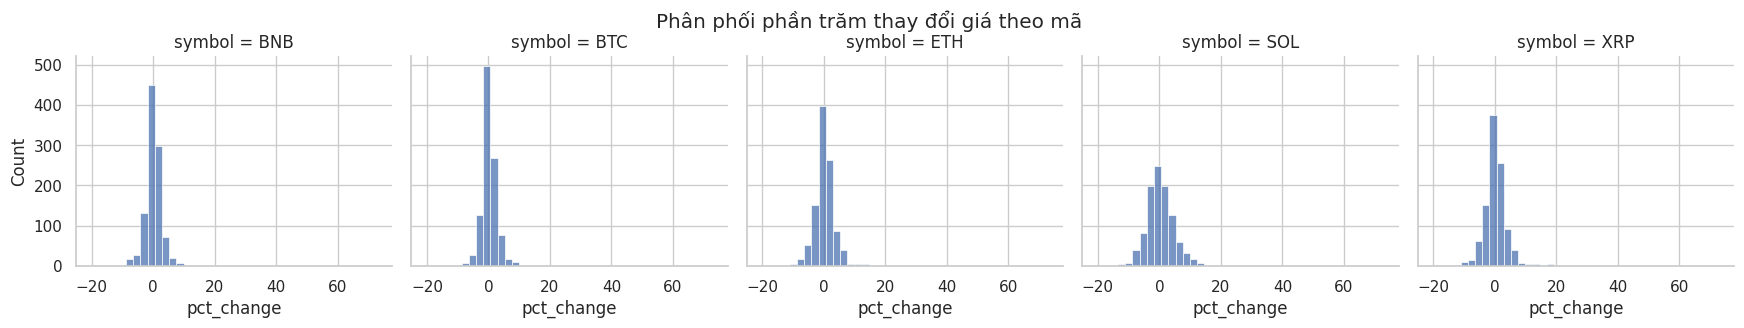

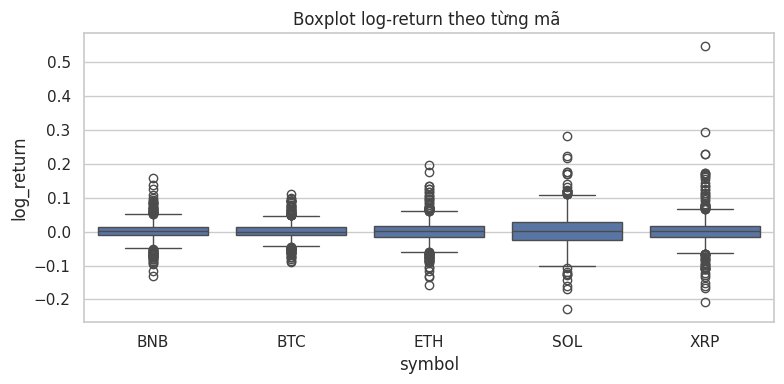

In [ ]:
# ============================================================
# 3.2) DESCRIPTIVE STATISTICS (Thống kê mô tả)
# ============================================================

desc_cols = ['Close','pct_change','log_return','Volume',
             'funding_Rate','fetch_fear_greed','google_interest',
             'hash_rate','tx_count','miners_revenue']

desc = df.groupby('symbol')[desc_cols].describe().round(3)
print("📊 3.2 — Summary Statistics by symbol")
display(desc)

# Histogram %change theo từng mã (chụp dùng cho báo cáo)
g = sns.displot(data=df, x='pct_change', col='symbol', kind='hist', height=3.2, aspect=1.1, bins=40)
g.fig.suptitle('Phân phối phần trăm thay đổi giá theo mã ', y=1.02)
plt.show()

# Boxplot log-return để thấy fat-tail (chụp dùng cho báo cáo)
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='symbol', y='log_return')
plt.title('Boxplot log-return theo từng mã ')
plt.xlabel('symbol'); plt.ylabel('log_return')
plt.show()


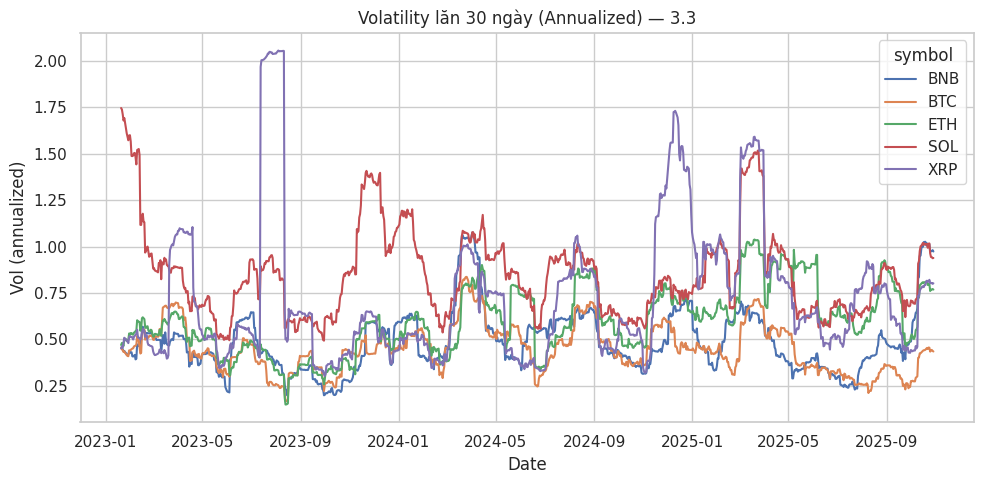

📉 3.3 — Risk metrics (Max Drawdown, Sharpe, Sortino)


,symbol,max_drawdown,max_drawdown_date,sharpe_annual,sortino_annual
0,BNB,-0.410124,2023-10-12,1.032204,1.471052
1,BTC,-0.280953,2025-04-08,1.451381,2.227076
2,ETH,-0.637520,2025-04-08,0.670997,0.985117
3,SOL,-0.597664,2025-04-08,1.184301,1.997868
4,XRP,-0.488352,2024-07-07,0.892754,1.442973


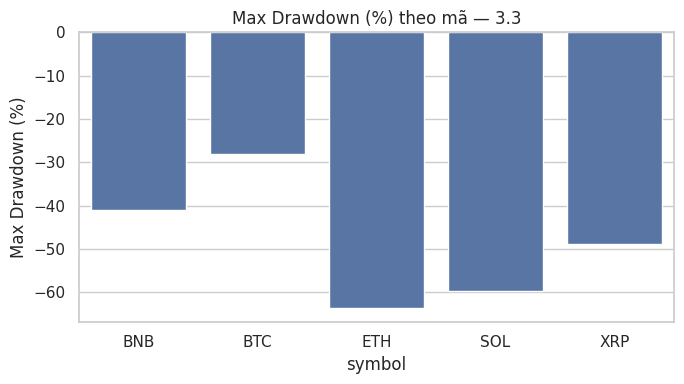

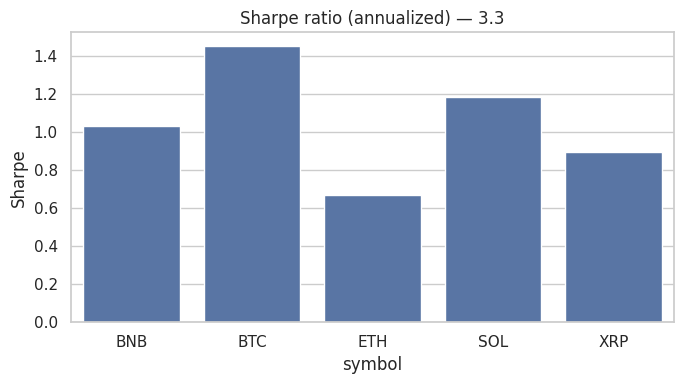

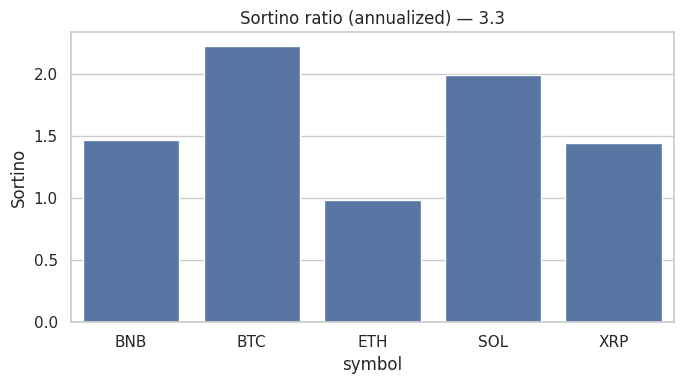

In [ ]:
# ============================================================
# 3.3) VOLATILITY & DRAWDOWN & RISK METRICS
# ============================================================

# --- Rolling Volatility 30D (annualized) ---
roll_vol = (df.set_index('Date')
              .groupby('symbol')['log_return']
              .rolling(window=30, min_periods=20)
              .std()
              .mul(np.sqrt(365))
              .reset_index(name='vol_30d_annual'))

plt.figure(figsize=(10,5))
sns.lineplot(data=roll_vol, x='Date', y='vol_30d_annual', hue='symbol')
plt.title('Volatility lăn 30 ngày (Annualized) — 3.3')
plt.xlabel('Date'); plt.ylabel('Vol (annualized)')
plt.show()

# --- Hàm tính Max Drawdown ---
def max_drawdown(price_series: pd.Series):
    peak = price_series.cummax()
    dd = price_series/peak - 1.0
    return dd.min(), dd.idxmin()

# --- Tính Sharpe/Sortino cơ bản (rf ~ 0) ---
def sharpe_ratio(returns, rf=0.0):
    # returns là log_return theo ngày
    mu = returns.mean()
    sd = returns.std(ddof=0)
    return np.nan if sd == 0 or np.isnan(sd) else (mu - rf) / sd * np.sqrt(365)

def sortino_ratio(returns, rf=0.0):
    downside = returns[returns < 0]
    dd = downside.std(ddof=0)
    mu = returns.mean()
    return np.nan if dd == 0 or np.isnan(dd) else (mu - rf) / dd * np.sqrt(365)

# --- Tổng hợp risk table ---
rows = []
for sym, g in df.groupby('symbol', sort=False):
    g = g.dropna(subset=['Close','log_return'])
    mdd, mdd_idx = max_drawdown(g['Close'])
    sr = sharpe_ratio(g['log_return'])
    sor = sortino_ratio(g['log_return'])
    rows.append({
        'symbol': sym,
        'max_drawdown': mdd,
        'max_drawdown_date': g.loc[mdd_idx, 'Date'] if pd.notna(mdd_idx) else pd.NaT,
        'sharpe_annual': sr,
        'sortino_annual': sor
    })
risk_tbl = pd.DataFrame(rows)
print("📉 3.3 — Risk metrics (Max Drawdown, Sharpe, Sortino)")
display(risk_tbl)

# Bar chart Max Drawdown (chụp cho báo cáo)
plt.figure(figsize=(7,4))
plot_dd = risk_tbl.copy()
plot_dd['MDD_%'] = plot_dd['max_drawdown']*100
sns.barplot(data=plot_dd, x='symbol', y='MDD_%')
plt.title('Max Drawdown (%) theo mã — 3.3')
plt.xlabel('symbol'); plt.ylabel('Max Drawdown (%)')
plt.show()

# Bar chart Sharpe
plt.figure(figsize=(7,4))
sns.barplot(data=risk_tbl, x='symbol', y='sharpe_annual')
plt.title('Sharpe ratio (annualized) — 3.3')
plt.xlabel('symbol'); plt.ylabel('Sharpe')
plt.show()

# Bar chart Sortino
plt.figure(figsize=(7,4))
sns.barplot(data=risk_tbl, x='symbol', y='sortino_annual')
plt.title('Sortino ratio (annualized) — 3.3')
plt.xlabel('symbol'); plt.ylabel('Sortino')
plt.show()



🔥 3.4 — Correlation matrix (BNB)


,pct_change,log_return,funding_Rate,hash_rate,tx_count,miners_revenue,Volume
pct_change,1.00,1.00,0.08,0.05,-0.01,0.04,0.04
log_return,1.00,1.00,0.08,0.05,-0.01,0.04,0.03
funding_Rate,0.08,0.08,1.00,0.10,0.03,0.06,0.01
hash_rate,0.05,0.05,0.10,1.00,0.19,0.65,-0.10
tx_count,-0.01,-0.01,0.03,0.19,1.00,0.08,-0.06
miners_revenue,0.04,0.04,0.06,0.65,0.08,1.00,0.12
Volume,0.04,0.03,0.01,-0.10,-0.06,0.12,1.00


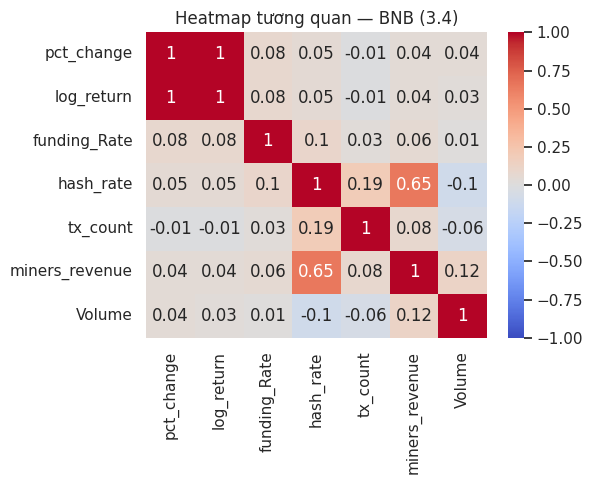


🔥 3.4 — Correlation matrix (BTC)


,pct_change,log_return,funding_Rate,hash_rate,tx_count,miners_revenue,Volume
pct_change,1.00,1.00,0.01,0.01,0.01,-0.00,0.10
log_return,1.00,1.00,0.01,0.01,0.01,-0.00,0.09
funding_Rate,0.01,0.01,1.00,-0.05,-0.00,0.18,0.09
hash_rate,0.01,0.01,-0.05,1.00,0.19,0.65,-0.26
tx_count,0.01,0.01,-0.00,0.19,1.00,0.08,-0.20
miners_revenue,-0.00,-0.00,0.18,0.65,0.08,1.00,-0.20
Volume,0.10,0.09,0.09,-0.26,-0.20,-0.20,1.00


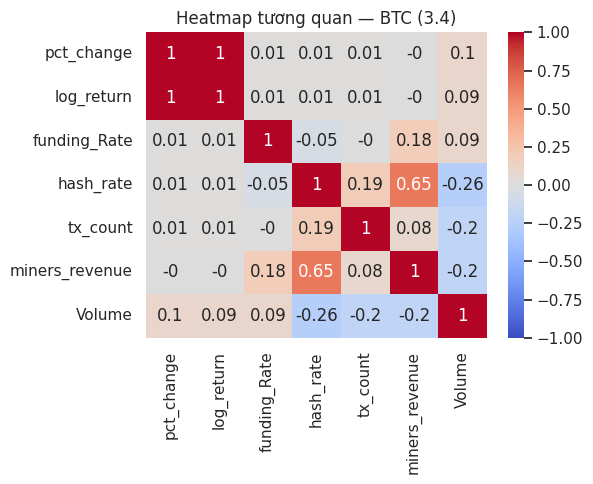


🔥 3.4 — Correlation matrix (ETH)


,pct_change,log_return,funding_Rate,hash_rate,tx_count,miners_revenue,Volume
pct_change,1.00,1.00,0.04,0.01,0.01,0.01,0.05
log_return,1.00,1.00,0.04,0.00,0.01,0.01,0.03
funding_Rate,0.04,0.04,1.00,-0.06,0.00,0.16,0.08
hash_rate,0.01,0.00,-0.06,1.00,0.19,0.65,0.14
tx_count,0.01,0.01,0.00,0.19,1.00,0.08,-0.15
miners_revenue,0.01,0.01,0.16,0.65,0.08,1.00,0.12
Volume,0.05,0.03,0.08,0.14,-0.15,0.12,1.00


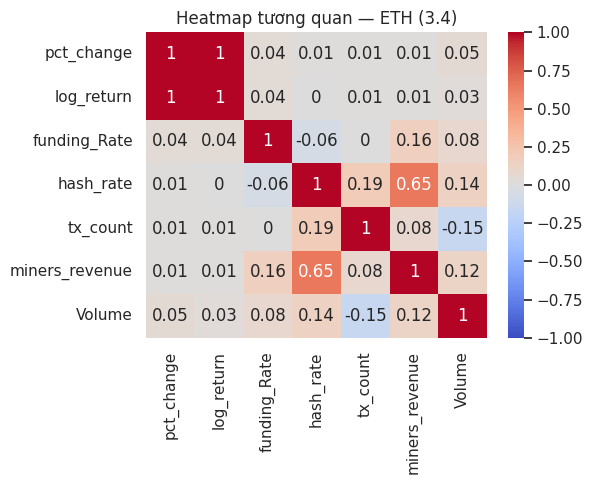


🔥 3.4 — Correlation matrix (SOL)


,pct_change,log_return,funding_Rate,hash_rate,tx_count,miners_revenue,Volume
pct_change,1.00,1.00,-0.05,-0.04,-0.02,-0.02,0.20
log_return,1.00,1.00,-0.05,-0.03,-0.01,-0.01,0.17
funding_Rate,-0.05,-0.05,1.00,-0.02,0.04,0.11,0.02
hash_rate,-0.04,-0.03,-0.02,1.00,0.19,0.65,-0.11
tx_count,-0.02,-0.01,0.04,0.19,1.00,0.08,-0.11
miners_revenue,-0.02,-0.01,0.11,0.65,0.08,1.00,0.04
Volume,0.20,0.17,0.02,-0.11,-0.11,0.04,1.00


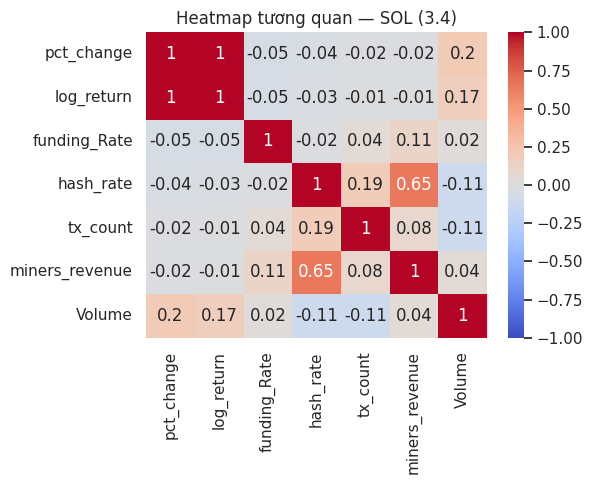


🔥 3.4 — Correlation matrix (XRP)


,pct_change,log_return,funding_Rate,hash_rate,tx_count,miners_revenue,Volume
pct_change,1.00,0.99,0.03,-0.00,0.01,-0.00,0.31
log_return,0.99,1.00,0.03,0.00,0.02,0.00,0.27
funding_Rate,0.03,0.03,1.00,-0.04,0.02,0.18,0.33
hash_rate,-0.00,0.00,-0.04,1.00,0.19,0.65,-0.12
tx_count,0.01,0.02,0.02,0.19,1.00,0.08,-0.05
miners_revenue,-0.00,0.00,0.18,0.65,0.08,1.00,0.00
Volume,0.31,0.27,0.33,-0.12,-0.05,0.00,1.00


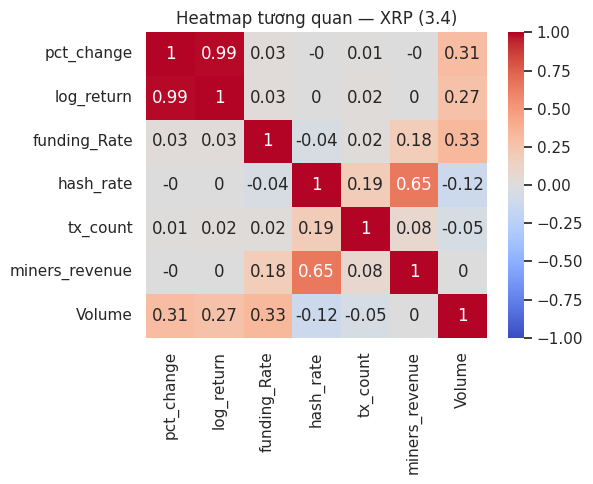

In [ ]:
# ============================================================
# 3.4) CORRELATION (từng mã) — Pearson giữa các biến
# ============================================================

corr_features = [
    'pct_change','log_return','funding_Rate','fetch_fear_greed',
    'google_interest','hash_rate','tx_count','miners_revenue','Volume'
]

for sym in df['symbol'].unique():
    sub = df[df['symbol'] == sym][corr_features].dropna(how='all')
    # Nếu quá nhiều NaN → bỏ các cột toàn NaN
    usable = sub.dropna(axis=1, how='all')
    if usable.shape[1] < 2:
        print(f"⚠️ {sym}: Không đủ dữ liệu để tính tương quan meaningful.")
        continue
    corr = usable.corr().round(2)
    print(f"\n🔥 3.4 — Correlation matrix ({sym})")
    display(corr)

    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
    plt.title(f'Heatmap tương quan — {sym} (3.4)')
    plt.show()


In [ ]:
# ============================================================
# 3.5) HỒI QUY NHANH: pct_change ~ factor (đo β, p-value, R)
# ============================================================

factors = ['funding_Rate','fetch_fear_greed','google_interest','hash_rate','tx_count','miners_revenue','Volume']

def quick_reg(y, x):
    ok = (~y.isna()) & (~x.isna())
    if ok.sum() < 10:
        return np.nan, np.nan, np.nan, ok.sum()
    r = linregress(x[ok], y[ok])
    return r.slope, r.pvalue, r.rvalue, ok.sum()

rows = []
for sym, g in df.groupby('symbol', sort=False):
    y = g['pct_change']
    for col in factors:
        beta, pval, r, n = quick_reg(y, g[col])
        rows.append({
            'symbol': sym,
            'factor': col,
            'beta': beta,
            'p_value': pval,
            'r_value': r,
            'n_obs': n
        })

reg_summary = pd.DataFrame(rows).sort_values(['symbol','p_value'], na_position='last')
print("📈 3.5 — Hồi quy nhanh (pct_change ~ factor)")
display(reg_summary.head(30))

# Bảng rút gọn top yếu tố có ý nghĩa (p<0.05) theo từng mã
def top_sig(df_reg, alpha=0.05, topk=3):
    out = []
    for sym in df_reg['symbol'].unique():
        tmp = df_reg[(df_reg['symbol']==sym) & (df_reg['p_value'].notna())].sort_values('p_value')
        out.append(tmp.head(topk))
    return pd.concat(out) if out else pd.DataFrame()

top_factors = top_sig(reg_summary, alpha=0.05, topk=3)
print("🏁 3.5 — Top yếu tố có ý nghĩa (nhỏ p-value) theo từng mã")
display(top_factors)


📈 3.5 — Hồi quy nhanh (pct_change ~ factor)


,symbol,factor,beta,p_value,r_value,n_obs
0,BNB,funding_Rate,9.924486e+02,1.044720e-02,0.079680,1032
3,BNB,hash_rate,1.138744e-09,9.198025e-02,0.052481,1032
5,BNB,miners_revenue,1.535903e-08,1.637421e-01,0.043382,1032
6,BNB,Volume,2.840654e-07,1.771514e-01,0.042043,1032
4,BNB,tx_count,-3.581514e-07,7.419671e-01,-0.010261,1032
1,BNB,fetch_fear_greed,NaN,NaN,NaN,0
2,BNB,google_interest,NaN,NaN,NaN,0
13,BTC,Volume,2.817242e-06,1.515878e-03,0.098560,1033
7,BTC,funding_Rate,3.899567e+02,6.728488e-01,0.013153,1033
10,BTC,hash_rate,2.365360e-10,6.967820e-01,0.012138,1033


🏁 3.5 — Top yếu tố có ý nghĩa (nhỏ p-value) theo từng mã


,symbol,factor,beta,p_value,r_value,n_obs
0,BNB,funding_Rate,9.924486e+02,1.044720e-02,0.079680,1032
3,BNB,hash_rate,1.138744e-09,9.198025e-02,0.052481,1032
5,BNB,miners_revenue,1.535903e-08,1.637421e-01,0.043382,1032
13,BTC,Volume,2.817242e-06,1.515878e-03,0.098560,1033
7,BTC,funding_Rate,3.899567e+02,6.728488e-01,0.013153,1033
10,BTC,hash_rate,2.365360e-10,6.967820e-01,0.012138,1033
20,ETH,Volume,5.334704e-07,1.427379e-01,0.045634,1033
14,ETH,funding_Rate,1.673982e+03,1.646796e-01,0.043265,1033
19,ETH,miners_revenue,6.338551e-09,6.355041e-01,0.014765,1033
27,SOL,Volume,2.992828e-07,1.330437e-10,0.198118,1033


🔁 3.6 — Corr giữa returns các coin (cùng ngày)


symbol,BNB,BTC,ETH,SOL,XRP
symbol,,,,,
BNB,1.00,0.63,0.65,0.56,0.42
BTC,0.63,1.00,0.79,0.71,0.54
ETH,0.65,0.79,1.00,0.69,0.57
SOL,0.56,0.71,0.69,1.00,0.52
XRP,0.42,0.54,0.57,0.52,1.00


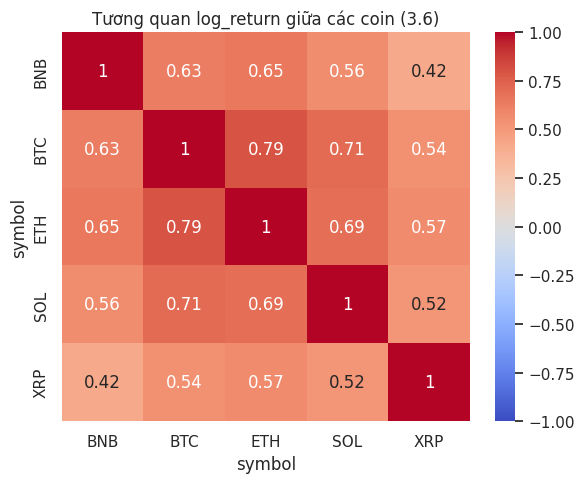

📌 3.6 — Beta vs BTC (r_i = α + β * r_BTC)


,symbol,beta_vs_BTC,p_value,r_value,n_obs
2,SOL,1.356233,1.933914e-157,0.707468,1032
1,ETH,1.066157,4.293692e-222,0.791088,1032
3,XRP,0.960075,1.290597e-80,0.544197,1032
0,BNB,0.706704,5.674286e-117,0.633697,1032


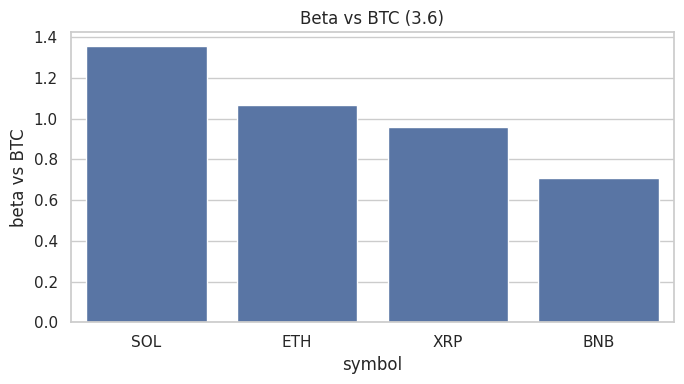

In [ ]:
# ============================================================
# 3.6) CROSS-MARKET: tương quan & Beta vs BTC
# ============================================================

# Ma trận tương quan giữa các coin (log_return)
ret_wide = df.pivot(index='Date', columns='symbol', values='log_return').dropna(how='all').copy()
# Bỏ cột rất rỗng (nếu có)
valid_cols = ret_wide.columns[ret_wide.notna().mean() > 0.7]  # giữ cột có >=70% dữ liệu
ret_wide = ret_wide[valid_cols].dropna()

print("🔁 3.6 — Corr giữa returns các coin (cùng ngày)")
corr_coins = ret_wide.corr().round(2)
display(corr_coins)

plt.figure(figsize=(6,5))
sns.heatmap(corr_coins, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Tương quan log_return giữa các coin (3.6)')
plt.show()

# Beta vs BTC (coi BTC như "thị trường") — regress r_i ~ r_BTC
if 'BTC' in ret_wide.columns:
    betas = []
    r_btc = ret_wide['BTC']
    for c in ret_wide.columns:
        if c == 'BTC':
            continue
        ok = (~r_btc.isna()) & (~ret_wide[c].isna())
        if ok.sum() < 30:
            beta = np.nan; p = np.nan; r = np.nan; n = ok.sum()
        else:
            res = linregress(r_btc[ok], ret_wide[c][ok])
            beta, p, r, n = res.slope, res.pvalue, res.rvalue, ok.sum()
        betas.append({'symbol': c, 'beta_vs_BTC': beta, 'p_value': p, 'r_value': r, 'n_obs': n})

    beta_tbl = pd.DataFrame(betas).sort_values('beta_vs_BTC', na_position='last', ascending=False)
    print("📌 3.6 — Beta vs BTC (r_i = α + β * r_BTC)")
    display(beta_tbl)

    # Bar chart beta (chụp cho báo cáo)
    plt.figure(figsize=(7,4))
    sns.barplot(data=beta_tbl, x='symbol', y='beta_vs_BTC')
    plt.title('Beta vs BTC (3.6)')
    plt.xlabel('symbol'); plt.ylabel('beta vs BTC')
    plt.show()
else:
    print("⚠️ Không có cột BTC trong dữ liệu để tính Beta vs BTC.")


# Data Visualization

## --- Setup ---

In [ ]:
# --- Setup ---
os.makedirs("data/picture", exist_ok=True)

df_clean = pd.read_csv("data/dataset_total_clean.csv")
df_scaled = pd.read_csv("data/dataset_scaled_total.csv")

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 5)

## BIỂU ĐỒ CHUNG CHO 5 COIN

### Waffle Chart: Tỷ trọng volume

In [ ]:
# --- Waffle Chart: Tỷ trọng volume ---
symbol_share = df_clean.groupby('symbol')['Volume'].sum().sort_values(ascending=False)
scaled_share = (symbol_share / symbol_share.sum() * 500).round(2)

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=scaled_share,
    title={'label': 'Tỷ trọng khối lượng giao dịch giữa các mã', 'loc': 'center', 'fontsize': 14},
    colors=sns.color_palette('pastel', n_colors=len(scaled_share)),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.savefig("data/picture/waffle_volume_share.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()


### Bar Chart: Giá trung bình Close

In [ ]:
plt.figure()
sns.barplot(x='symbol', y='Close', data=df_clean, ci=None, palette='viridis')
plt.title("Giá trung bình (Close) của từng coin")
plt.savefig("data/picture/bar_avg_close.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

### Pie Chart: miners_revenue

In [ ]:
plt.figure()
miner_sum = df_clean.groupby('symbol')['miners_revenue'].sum()
plt.pie(miner_sum, labels=miner_sum.index, autopct='%1.1f%%', startangle=90)
plt.title("Tỷ trọng miners_revenue giữa các coin")
plt.savefig("data/picture/pie_miner_revenue.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

### Area Chart: Close theo thời gian

In [ ]:
plt.figure()
for sym in df_clean['symbol'].unique():
    df_sub = df_clean[df_clean['symbol'] == sym]
    plt.plot(df_sub['Date'], df_sub['Close'], label=sym)
plt.legend()
plt.title("So sánh biến động giá Close theo thời gian (Clean)")
plt.savefig("data/picture/area_close_all.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

## BIỂU ĐỒ CHI TIẾT TỪNG COIN

In [ ]:
# Giả sử bạn đã có df_clean và df_scaled sẵn
# df_clean = pd.read_csv("data/dataset_total_clean.csv")
# df_scaled = pd.read_csv("data/dataset_scaled_total.csv")

for sym in df_clean['symbol'].unique():
    os.makedirs(f"data/{sym}/pic", exist_ok=True)

    df_c = df_clean[df_clean['symbol'] == sym]
    df_s = df_scaled[df_scaled['symbol'] == sym]

    # --- Histogram ---
    plt.figure()
    sns.histplot(df_c['log_return'], kde=True, bins=20)
    plt.title(f"{sym}: Phân bố log_return (Clean)")
    plt.savefig(f"data/{sym}/pic/hist_log_return.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Scatter ---
    plt.figure()
    sns.scatterplot(x='funding_Rate', y='Close', data=df_c)
    plt.title(f"{sym}: Funding Rate vs Close (Clean)")
    plt.savefig(f"data/{sym}/pic/scatter_funding_vs_close.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Area Chart ---
    plt.figure()
    plt.fill_between(df_c['Date'], df_c['Close'], alpha=0.5)
    plt.title(f"{sym}: Biến động giá Close (Clean)")
    plt.savefig(f"data/{sym}/pic/area_close.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Bar Chart ---
    df_c = df_c.copy()
    df_c['Date'] = pd.to_datetime(df_c['Date'], errors='coerce')  # ép chuyển datetime
    df_c['week'] = df_c['Date'].apply(lambda x: x.isocalendar().week if pd.notnull(x) else np.nan)


    weekly = df_c.groupby('week')['Volume'].mean()
    plt.figure()
    sns.barplot(x=weekly.index, y=weekly.values, color='skyblue')
    plt.title(f"{sym}: Volume trung bình theo tuần")
    plt.savefig(f"data/{sym}/pic/bar_weekly_volume.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Pie Chart (Scaled - MinMax absolute values) ---
    plt.figure()
    feat_avg = df_s[['Open','High','Low','Close','Volume']].mean().abs().values.reshape(-1, 1)

    # Scale lại 0–1 để biểu đồ có tỷ lệ hợp lý
    scaler = MinMaxScaler()
    feat_scaled = scaler.fit_transform(feat_avg).flatten()

    plt.pie(feat_scaled, labels=['Open','High','Low','Close','Volume'], autopct='%1.1f%%')
    plt.title(f"{sym}: Tỷ trọng trung bình các biến chính (Scaled - MinMax)")
    plt.savefig(f"data/{sym}/pic/pie_features_scaled.png", bbox_inches='tight', dpi=300)
    plt.close()

print("✅ Đã tạo toàn bộ biểu đồ cho cả dữ liệu Clean và Scaled (Pie Chart fix bằng MinMaxScaler).")


# ...........................................................................................................................

In [ ]:
import os

def print_tree(start_path=".", indent=""):
    for item in os.listdir(start_path):
        path = os.path.join(start_path, item)
        if os.path.isdir(path):
            print(indent + "📁 " + item)
            print_tree(path, indent + "    ")
        else:
            print(indent + "📄 " + item)

# 🔧 Chạy hàm này ở thư mục gốc dự án (nơi chứa index.html, data/, api/...)
print_tree(".")


In [ ]:
import os
import json

# 📁 Thư mục gốc chứa các folder coin
DATA_DIR = "data"
OUT_PATH = os.path.join(DATA_DIR, "picture", "manifest.json")

# 🧩 Các từ khóa nhận diện loại biểu đồ (đặt tên gợi ý cho AI / web)
chart_keywords = {
    "area": "price_trend",
    "bar": "volume_weekly",
    "hist": "volatility",
    "pie": "composition",
    "scatter": "funding_vs_close",
}

manifest = {}

# --- Quét toàn bộ thư mục data/ ---
for symbol in os.listdir(DATA_DIR):
    coin_path = os.path.join(DATA_DIR, symbol)
    if not os.path.isdir(coin_path) or symbol.lower() == "picture":
        continue

    pic_path = os.path.join(coin_path, "pic")
    if not os.path.exists(pic_path):
        continue

    charts = {}
    for file in os.listdir(pic_path):
        if file.endswith(".png"):
            name, _ = os.path.splitext(file)
            # Xác định loại biểu đồ dựa theo từ khóa trong tên file
            matched = next((v for k, v in chart_keywords.items() if k in name.lower()), name)
            rel_path = os.path.join("data", symbol, "pic", file).replace("\\", "/")
            charts[matched] = rel_path

    manifest[symbol.upper()] = {"charts": charts}

# --- Lưu manifest ra file JSON ---
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=4, ensure_ascii=False)

print(f"✅ Đã tạo manifest.json tại: {OUT_PATH}")
print(f"📊 Tổng số coin: {len(manifest)}")
print(json.dumps(manifest, indent=2, ensure_ascii=False))
